### IMPORTS ###

In [32]:
import dill
import torch
import os
import numpy as np
from typing import Tuple, List
from stl.signals import Signal
from stl.utility import Interval
import matplotlib.pyplot as plt
import math
import time

### DEFINITIONS ###

In [15]:

def computeSampleSize(dataset, windowSize):
	count = 0
	for entry in dataset:
		signal: Signal = entry[0][0]
		lastTime = signal.computeLargestTimeBefore(signal.getTime(-1) - windowSize)
		count += signal.computeIndexForTime(lastTime) + 1
	return count

class MyOutputActivationFunctor(torch.nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self, prediction):
		""" Expects prediction to be a torch.Tensor;
		Should contain one batch worth of data, each individual prediction
		is a combination of [mean, variance].
		So, overall, should be a Tensor of size [x, 2].
		Output is that same dimension.
		prediction[:,0] is unchanged.
		prediction[:,1] is returned as (prediction[:,1])^2 + self.eps
		
		This method simply ensures that the returned value will always be positive, as required by GaussianNLLLoss."""
		out = torch.zeros_like(prediction)
		out[:,0] = prediction[:,0]
		out[:,1] = torch.square(prediction[:,1])
		return out
		

class CartpoleRobustnessEstimator(torch.nn.Module):
	""" Estimator for the cart pole robustness. """

	def __init__(self):
		super().__init__()
		self.eps = 1e-6
		self.convActivation = torch.nn.ReLU()
		self.fcActivation = torch.nn.ReLU()
		self.lossFunction = torch.nn.GaussianNLLLoss(eps=self.eps)
		self.output = MyOutputActivationFunctor()
		self.model = torch.nn.Sequential(
				torch.nn.Conv1d(2, 4, 10),
				self.convActivation,
		    torch.nn.MaxPool1d(kernel_size=5, stride=2, padding=0),  #
				self.convActivation,
				torch.nn.Conv1d(4, 4, 5),
		    torch.nn.AdaptiveMaxPool1d(25),  #
				torch.nn.Flatten(),
				self.fcActivation,
				torch.nn.Linear(100, 256),
				self.fcActivation,
				torch.nn.Linear(256, 2),
				self.output
		).cuda()

	def forward(self, x):
		prediction = self.model(x)
		return prediction

	def train(self, dataSet, batchSize, epochCount):
		"""
		Trains the model on the entirety of the given data set.
		Expected formats: dataSet: List[Tensor[Size(2,variable)]], results: List[Tensor[Size(1,)]], batchSize: unsigned integer
		"""
		self.model.train()
		self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)
		losses = []
		epochIndex = 0
		while epochIndex < epochCount:
			# Randomly go through the data
			permutedIndices = torch.randperm(len(dataSet))
			losses.append([])
			for i in range(0, len(dataSet), batchSize):
				self.optimizer.zero_grad()
				# Indices for the current batch
				indices = permutedIndices[i: i+batchSize]
				# Create the input tensor and target tensor
				batch = torch.cat(tuple(dataSet[i][0] for i in indices), dim = 0)
				targets = torch.cat(tuple(dataSet[i][1] for i in indices))
				# Then, using that input, get a prediction
				predictions = self.forward(batch)
				means = predictions[:,0]
				variances = predictions[:,1]
				# Compute the loss
				loss = self.lossFunction(means, targets, variances)
				# Back-propagation
				loss.backward()
				self.optimizer.step()
				# Storage for visualizing
				losses[-1].append(loss.item())
			print(f"Completed epoch {epochIndex}")
			epochIndex += 1
		return losses

	def test(self, dataSet):
		"""
		Tests the model. Prints performance stats.
		"""
		self.model.eval()
		dataIndex = 0
		outputs = []
		for entry in dataSet:
			prediction = self.forward(entry[0])
			outputs.append((prediction.squeeze(), entry[1].item()))
			dataIndex += 1
			if dataIndex % 5000 == 0:
				print(f"Handled {dataIndex} out of {len(dataSet)} samples")
		print(f"Handled all samples: {dataIndex} out of {len(dataSet)}")
		return outputs

def preprocess(dataset, windowSize):
	""" Expected data in-format List[Tuple(List[Signal, Signal], Signal)]
	out-format: List[Tensor[values, values], Tensor[labelvalues]]"""
	# This behaviour is cartpole specific, since the data sets differ between environments.
	entry: Tuple[Tuple[Signal, Signal], Signal]
	results = []
	# Iterate over data and find the longest signal
	# So we can null-pad the tensors
	
	longestSignal = 0
	for entry in dataset:
		entry[0][0], entry[0][1] = Signal.computeComparableSignals(entry[0][0], entry[0][1])
		for cp in entry[0][0].getCheckpoints():
			longestSignal = max(
				entry[0][0].computeInterval(Interval(cp.getTime(), cp.getTime() + windowSize)).getCheckpointCount(), #
				entry[0][1].computeInterval(Interval(cp.getTime(), cp.getTime() + windowSize)).getCheckpointCount(), #
				longestSignal #
			)
	for entry in dataset:
		pSignal: Signal = entry[0][0]
		cSignal: Signal = entry[0][1]
		labels = entry[1]
		i = 0
		# pSignal and cSignal now have matching timestamps
		while pSignal.getTime(-1) >= pSignal.getTime(i) + windowSize:  # Also applies to cSignal
			interval = Interval(pSignal.getTime(i), pSignal.getTime(i) + windowSize)
			pIn = pSignal.computeInterval(interval)
			cIn = cSignal.computeInterval(interval)
			inTensor = torch.tensor([[pIn.getValues() + ([0] * (longestSignal - pIn.getCheckpointCount())), cIn.getValues() + ([0] * (longestSignal - cIn.getCheckpointCount()))]]).cuda()
			outTensor = torch.tensor([labels.computeInterpolatedValue(pSignal.getTime(i))]).cuda()
			results.append((inTensor, outTensor))
			i += 1
	return results

### Re-import data and write to file ###

In [81]:
print("Cartpole data import is enabled!")
from examples.cartpole.data_converted import data
print("Imported cartpole train data")

trainData = data[:-10]
testData = data[-10:]

trainData = preprocess(trainData, 50)
testData = preprocess(testData, 50)
with open("cartpoleTrainData.pickle", "wb") as f:
	torch.save(trainData, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)
with open("cartpoleTestData.pickle", "wb") as f:
	torch.save(testData, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)

Cartpole data import is enabled!
Imported cartpole train data


### MODEL LOAD ###

FROM FILE

In [4]:
saveFileName = "cartpoleEstimator.pickle"
if os.path.exists(saveFileName):
	with open(saveFileName, 'rb') as f:
		estimator = torch.load(f, pickle_module=dill)

NEW

In [39]:
torch.manual_seed(6)
estimator = CartpoleRobustnessEstimator()

Model Write

In [ ]:
saveFileName = "cartpoleEstimator.pickle"
with open(saveFileName, "wb") as f:
	torch.save(estimator, f, pickle_module=dill, pickle_protocol=dill.HIGHEST_PROTOCOL)

### DATA LOADING ###

In [5]:
with open("cartpoleTrainData.pickle", "rb") as f:
	trainData = torch.load(f, pickle_module=dill, map_location='cuda:0')
with open("cartpoleTestData.pickle", "rb") as f:
	testData = torch.load(f, pickle_module=dill, map_location='cuda:0')

### TRAIN THE MODEL ###

In [41]:
losses = estimator.train(trainData, batchSize=256, epochCount=200)

Completed epoch 0
2.1674790382385254


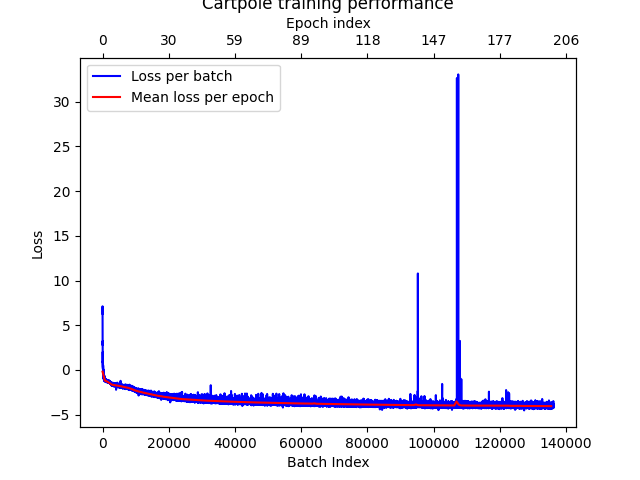

In [18]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot()
lossPerBatch = [l for x in losses for l in x]
ax.plot(lossPerBatch, label="Loss per batch", color='blue')
ax.plot(range(0, len(lossPerBatch), math.ceil(len(lossPerBatch) / len(losses))), [sum(x) / len(x) for x in losses], label="Mean loss per epoch", color='red')
ax.set_xlabel("Batch Index")
ax.set_ylabel("Loss")
ax.set_title("Cartpole training performance")


xticks = [0, 20000, 40000, 60000, 80000, 100000, 120000, 140000]
ax2 = ax.twiny()
ax2.set_xlabel("Epoch index")
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(xticks)
ax2.set_xticklabels([math.ceil(x * len(losses) / len(lossPerBatch)) for x in xticks])
ax.legend()
plt.show()

### TEST THE MODEL ###

Handled all samples: 4178 out of 4178


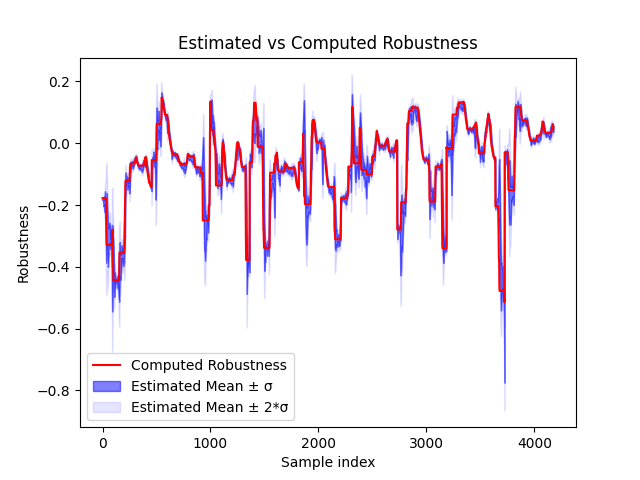

In [29]:
%matplotlib widget
testResults = estimator.test(testData)

### Output Visualization ###

In [ ]:
times = list(range(len(testResults)))
plt.plot(times, [x[1] for x in testResults], label="Computed Robustness", color='red')
y1 = [x[0][0].item() + math.sqrt(x[0][1].item()) for x in testResults]
y2 = [x[0][0].item() - math.sqrt(x[0][1].item()) for x in testResults]
plt.fill_between(times, y1, y2, color='blue', alpha=0.5, label=u"Estimated Mean \u00B1 \u03C3")
y1 = [x[0][0].item() + 2*math.sqrt(x[0][1].item()) for x in testResults]
y2 = [x[0][0].item() - 2*math.sqrt(x[0][1].item()) for x in testResults]
plt.fill_between(times, y1, y2, color='blue', alpha=0.1, label=u"Estimated Mean \u00B1 2*\u03C3")
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Robustness")
plt.title("Estimated vs Computed Robustness")
plt.show()

### Show amount of misses in test ###

In [31]:
offsets = {}
signWrongs = 0
wrongValues = []
for i in testResults:
	# i = (outputTensor, expectedValue)
	expectedMean = i[0][0].item()
	stddev = math.sqrt(i[0][1].item())
	expected = i[1]

	amountOfVariances = math.ceil(
		abs(expected - expectedMean) / stddev
	)
	if amountOfVariances not in offsets:
		offsets[amountOfVariances] = 1
	else:
		offsets[amountOfVariances] += 1
	if math.copysign(1, i[0][0].item()) != math.copysign(1, i[1]):
		signWrongs += 1
		wrongValues.append(i[0][0].item())
print(signWrongs)
print(offsets)
#print(wrongValues)
print(sum(wrongValues)/len(wrongValues))
print(max([abs(x) for x in wrongValues]))

164
{2: 1190, 1: 2835, 3: 116, 4: 27, 9: 2, 7: 1, 5: 6, 6: 1}
0.012361069175800899
0.09270492196083069


### PRINT PARAMETERS ###

In [209]:
model_parameters = filter(lambda p: p.requires_grad, estimator.model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
with open('params.txt', 'w') as f:
	f.write(list(filter(lambda p: p.requires_grad, estimator.model.parameters())).__str__())

18130


# Runtime Measurement #

Handled 5000 out of 178280 samples
Handled 10000 out of 178280 samples
Handled 15000 out of 178280 samples
Handled 20000 out of 178280 samples
Handled 25000 out of 178280 samples
Handled 30000 out of 178280 samples
Handled 35000 out of 178280 samples
Handled 40000 out of 178280 samples
Handled 45000 out of 178280 samples
Handled 50000 out of 178280 samples
Handled 55000 out of 178280 samples
Handled 60000 out of 178280 samples
Handled 65000 out of 178280 samples
Handled 70000 out of 178280 samples
Handled 75000 out of 178280 samples
Handled 80000 out of 178280 samples
Handled 85000 out of 178280 samples
Handled 90000 out of 178280 samples
Handled 95000 out of 178280 samples
Handled 100000 out of 178280 samples
Handled 105000 out of 178280 samples
Handled 110000 out of 178280 samples
Handled 115000 out of 178280 samples
Handled 120000 out of 178280 samples
Handled 125000 out of 178280 samples
Handled 130000 out of 178280 samples
Handled 135000 out of 178280 samples
Handled 140000 out of

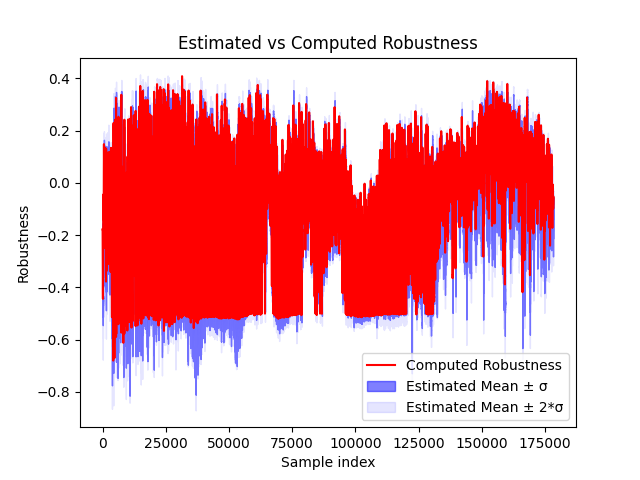

Estimator took 134.9470193386078


In [33]:
fullData = testData + trainData


start = time.time()
x = estimator.test(fullData)
end = time.time()
print(f"Estimator took {end - start}")